In [3]:
import torch
import numpy as np
from PIL import Image
import os
import onnxruntime as rt
import torchvision.transforms as transforms
import onnxruntime as ort
import torch.nn.functional as F
import cv2



In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [ ]:
def letterbox(img, new_shape=(2048, 2048), color=(114, 114, 114)):
    orig_w, orig_h = img.size
    r = min(new_shape[0] / orig_h, new_shape[1] / orig_w)
    new_unpad = int(orig_w * r), int(orig_h * r)
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]
    dw /= 2
    dh /= 2

    # resize
    img_resized = img.resize(new_unpad, Image.BILINEAR)
    # create padded image
    new_img = Image.new("RGB", new_shape, color)
    new_img.paste(img_resized, (int(dw), int(dh)))
    return new_img, new_unpad[0], new_unpad[1], int(dw), int(dh), r

def draw_contours_on_image(image_path, detections):
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Cannot load: {image_path}")

    for det in detections:
        mask = det["mask"].astype(np.uint8)
        box = det["box"]
        score = det["score"]

        # find contours
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL,
                                       cv2.CHAIN_APPROX_SIMPLE)

        color = (0, 255, 0)

        # draw all contours
        cv2.drawContours(img, contours, -1, color, 2)

        # draw bounding box
        x1, y1, x2, y2 = box
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

        cv2.putText(img,
                    f"{score:.2f}",
                    (x1, max(y1 - 5, 0)),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.7,
                    color,
                    2)

    return img

def post_process_segmentation(pred, proto, mask_threshold,
                              pad_x, pad_y,
                              orig_w, orig_h, new_w, new_h):
    """
    Convert ONNX outputs into masks + boxes in ORIGINAL IMAGE coordinates.
    """

    pred = pred[0]               # (300, 38)
    proto = proto[0]             # (32, 256, 256)

    # remove zero rows (confidence = 0)
    pred = pred[pred[:, 4] > 0]

    if len(pred) == 0:
        return []

    boxes = pred[:, 0:4]                # x1,y1,x2,y2 in letterboxed coordinates
    scores = pred[:, 4]
    class_ids = pred[:, 5].astype(int)
    coeffs = pred[:, 6:]                # (N, 32)

    # compute prototype masks (256×256 → 1024×1024 → unpad → orig)
    masks = []
    for c in coeffs:
        m = np.tensordot(c, proto.reshape(32, -1), axes=1)
        m = m.reshape(256, 256)
        m = 1 / (1 + np.exp(-m))           # sigmoid
        m = cv2.resize(m, (new_w, new_h))

        # unpad
        m = m[pad_y:pad_y+new_h, pad_x:pad_x+new_w]

        # resize to original
        m = cv2.resize(m, (orig_w, orig_h))
        masks.append(m > mask_threshold)

    # convert boxes to original-image coordinates
    final_boxes = []
    for b in boxes:
        x1, y1, x2, y2 = b

        # remove padding
        x1 -= pad_x
        x2 -= pad_x
        y1 -= pad_y
        y2 -= pad_y

        # scale to original image
        x1 = x1 * (orig_w / new_w)
        x2 = x2 * (orig_w / new_w)
        y1 = y1 * (orig_h / new_h)
        y2 = y2 * (orig_h / new_h)

        final_boxes.append([int(x1), int(y1), int(x2), int(y2)])

    detections = []
    for box, score, cls, mask in zip(final_boxes, scores, class_ids, masks):
        detections.append({
            "box": box,          # [x1,y1,x2,y2] in ORIGINAL coordinates
            "score": float(score),
            "class": int(cls),
            "mask": mask         # binary mask in ORIGINAL resolution (orig_h×orig_w)
        })

    return detections


In [ ]:
detection_sess = rt.InferenceSession("models/LineDetectionv4.onnx", providers=rt.get_available_providers())
input_name = detection_sess.get_inputs()[0].name
output_name = detection_sess.get_outputs()[0].name

In [ ]:
img = Image.open("images/0_page.jpeg").convert("RGB")
orig_w, orig_h = img.size

padded, new_w, new_h, pad_x, pad_y, scale = letterbox(img, new_shape=(1024,1024))
image = np.array(padded).astype(np.float32) / 255.0
image = image.transpose(2,0,1)[None,...]

pred, proto = detection_sess.run(None, {input_name: image})

detections = post_process_segmentation(
    pred, proto, 0.5,
    pad_x, pad_y,
    orig_w, orig_h,
    new_w, new_h
)

out_img = draw_contours_on_image("images/0_page.jpeg", detections)
cv2.imwrite("detections_output.jpg", out_img)


In [ ]:
class CTCLabelConverter(object):
    """ Convert between text-label and text-index """

    #def __init__(self, character, separator = []):
    def __init__(self, character, separator_list = {}, dict_pathlist = {}):
        # character (str): set of the possible characters.
        dict_character = list(character)

        #special_character = ['\xa2', '\xa3', '\xa4','\xa5']
        #self.separator_char = special_character[:len(separator)]

        self.dict = {}
        #for i, char in enumerate(self.separator_char + dict_character):
        for i, char in enumerate(dict_character):
            # NOTE: 0 is reserved for 'blank' token required by CTCLoss
            self.dict[char] = i + 1

        self.character = ['[blank]'] + dict_character  # dummy '[blank]' token for CTCLoss (index 0)
        #self.character = ['[blank]']+ self.separator_char + dict_character  # dummy '[blank]' token for CTCLoss (index 0)
        self.separator_list = separator_list

        separator_char = []
        for lang, sep in separator_list.items():
            separator_char += sep

        self.ignore_idx = [0] + [i+1 for i,item in enumerate(separator_char)]

        dict_list = {}
        for lang, dict_path in dict_pathlist.items():
            with open(dict_path, "rb") as input_file:
                word_count = pickle.load(input_file)
            dict_list[lang] = word_count
        self.dict_list = dict_list

    def encode(self, text, batch_max_length=25):
        """convert text-label into text-index.
        input:
            text: text labels of each image. [batch_size]

        output:
            text: concatenated text index for CTCLoss.
                    [sum(text_lengths)] = [text_index_0 + text_index_1 + ... + text_index_(n - 1)]
            length: length of each text. [batch_size]
        """
        length = [len(s) for s in text]
        text = ''.join(text)
        text = [self.dict[char] for char in text]

        return (torch.IntTensor(text), torch.IntTensor(length))

    def decode_greedy(self, text_index, length):
        """ convert text-index into text-label. """
        texts = []
        index = 0
        for l in length:
            t = text_index[index:index + l]

            char_list = []
            for i in range(l):
                if t[i] not in self.ignore_idx and (not (i > 0 and t[i - 1] == t[i])):  # removing repeated characters and blank (and separator).
                #if (t[i] != 0) and (not (i > 0 and t[i - 1] == t[i])):  # removing repeated characters and blank (and separator).
                    char_list.append(self.character[t[i]])
            text = ''.join(char_list)

            texts.append(text)
            index += l
        return texts


class AttnLabelConverter(object):
    """ Convert between text-label and text-index """

    def __init__(self, character):
        # character (str): set of the possible characters.
        # [GO] for the start token of the attention decoder. [s] for end-of-sentence token.
        list_token = ['[GO]', '[s]']  # ['[s]','[UNK]','[PAD]','[GO]']
        list_character = list(character)
        self.character = list_token + list_character

        self.dict = {}
        for i, char in enumerate(self.character):
            # print(i, char)
            self.dict[char] = i

    def encode(self, text, batch_max_length=25):
        """ convert text-label into text-index.
        input:
            text: text labels of each image. [batch_size]
            batch_max_length: max length of text label in the batch. 25 by default

        output:
            text : the input of attention decoder. [batch_size x (max_length+2)] +1 for [GO] token and +1 for [s] token.
                text[:, 0] is [GO] token and text is padded with [GO] token after [s] token.
            length : the length of output of attention decoder, which count [s] token also. [3, 7, ....] [batch_size]
        """
        length = [len(s) + 1 for s in text]  # +1 for [s] at end of sentence.
        # batch_max_length = max(length) # this is not allowed for multi-gpu setting
        batch_max_length += 1
        # additional +1 for [GO] at first step. batch_text is padded with [GO] token after [s] token.
        batch_text = torch.LongTensor(len(text), batch_max_length + 1).fill_(0)
        for i, t in enumerate(text):
            text = list(t)
            text.append('[s]')
            text = [self.dict[char] for char in text]
            batch_text[i][1:1 + len(text)] = torch.LongTensor(text)  # batch_text[:, 0] = [GO] token
        return (batch_text.to(device), torch.IntTensor(length).to(device))

    def decode(self, text_index, length):
        """ convert text-index into text-label. """
        texts = []
        for index, l in enumerate(length):
            text = ''.join([self.character[i] for i in text_index[index, :]])
            texts.append(text)
        return texts
    
def CRNN_center_and_resize_image(img, target_size=(1220, 80)):
    """
    Resize the image to fit inside target_size while maintaining aspect ratio.
    If the image is smaller, center it on a black background of target_size.
    """
    if isinstance(img, str):
       img = Image.open(img)
    target_w, target_h = target_size
    img_w, img_h = img.size

    if img_w > target_w or img_h > target_h:
        img.thumbnail((target_w, target_h), Image.LANCZOS)
    new_img = Image.new("RGB", (target_w, target_h), color="black")
    paste_x = (target_w - img.width) // 2
    paste_y = (target_h - img.height) // 2
    new_img.paste(img, (paste_x, paste_y))

    return new_img

def CRNN_preprocess_image(image_path, config, return_tensor=True):
    """
    Complete preprocessing pipeline for the text recognition model.
    
    Args:
        image_path: Path to image or PIL Image
        config: Model configuration object
        return_tensor: Whether to return PyTorch tensor or PIL Image
    
    Returns:
        Preprocessed image tensor or PIL Image
    """
    input_channels = 3
    
    processed_pil = CRNN_center_and_resize_image(image_path, (config[0], config[1]))
    
    if not return_tensor:
        return processed_pil
    
    image_np = np.array(processed_pil)
    
    image_np = image_np.astype(np.float32) / 255.0
    
    # if getattr(config, 'contrast_adjust', False):
    #     image_np = (image_np - np.mean(image_np)) / (np.std(image_np) + 1e-8)
    
    if input_channels == 1:
        image_tensor = torch.from_numpy(image_np).unsqueeze(0) 
        image_tensor = (image_tensor - 0.5) / 0.5
    else:
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        image_tensor = transform(processed_pil)
    
    # Add batch dimension: (1, C, H, W)
    image_tensor = image_tensor.unsqueeze(0)
    
    return image_tensor

def CRNN_load_onnx_model(onnx_path):
    """Load ONNX model as a runtime session."""
    session = ort.InferenceSession(onnx_path)
    return session

def CRNN_inference_onnx_model(session, converter, image_path):
    batch_max_length = 200
    character = """०१२३४५६७८९0123456789!"#$%&'()*+,-./:;<=>?@[\]^_`{}~।॥—‘’“”… अआइईउऊऋएऐओऔअंअःकखगघङचछजझञटठडढणतथदधनपफबभमयरलवशषसहक्षत्रज्ञािीुूृेैोौंःँॅॉ"""
    # Preprocess image
    image_tensor = CRNN_preprocess_image(image_path, (1220,80))  # [1, C, H, W]
    image_np = image_tensor.cpu().numpy().astype(np.float32)

    batch_size = image_np.shape[0]
    text_input = np.zeros((batch_size, batch_max_length), dtype=np.int64)

    # Run ONNX inference
    outputs = session.run(None, {"input": image_np })
    preds = outputs[0]  # [batch, seq_len, num_classes]

    if converter == "CTC":
        preds_size = np.array([preds.shape[1]] * batch_size, dtype=np.int32)
        preds_index = preds.argmax(axis=2).flatten()
        converter_class = CTCLabelConverter(character)
        preds_str = converter_class.decode_greedy(preds_index, preds_size)
        return preds_str[0]

    elif converter == "Attn":
        preds = preds[:, :batch_max_length - 1, :]
        preds_index = preds.argmax(axis=2)
        converter_class = AttnLabelConverter(character)
        preds_str = converter_class.decode(torch.from_numpy(preds_index), 
                                     torch.IntTensor([batch_max_length] * batch_size))

        preds_prob = F.softmax(torch.from_numpy(preds), dim=2)
        preds_max_prob, _ = preds_prob.max(dim=2)

        final_result = []
        for pred, pred_max_prob in zip(preds_str, preds_max_prob):
            eos_pos = pred.find('[s]')
            if eos_pos != -1:
                pred = pred[:eos_pos]
                pred_max_prob = pred_max_prob[:eos_pos]
            final_result.append(pred)
        return final_result

    return None


In [ ]:
onnx_session = CRNN_load_onnx_model("models/ResNetBiLSTMCTCv1.onnx")

all_entries = os.listdir("images/crops")
files_only = [os.path.join("images/crops", entry) for entry in all_entries if os.path.isfile(os.path.join("images/crops", entry))]

for index, string in enumerate(files_only):
    if index == 5:
        break
    #visualize_crnn_preprocessing(string, config)
    print(CRNN_inference_onnx_model(onnx_session, "CTC", string))


# onnx_session = CRNN_load_onnx_model("models/ResNetBiLSTMAttnv1.onnx")

# all_entries = os.listdir("images/crops")
# files_only = [os.path.join("images/crops", entry) for entry in all_entries if os.path.isfile(os.path.join("images/crops", entry))]

# for index, string in enumerate(files_only):
#     if index == 5:
#         break
#     #visualize_crnn_preprocessing(string, config)
#     print(CRNN_inference_onnx_model(onnx_session, "Attn", string))



In [ ]:
import os
from PIL import Image
import numpy as np

os.makedirs("temp_crops", exist_ok=True)
image_path = "images/202_page.jpg"
detection_sess = rt.InferenceSession("models/LineDetectionv4.onnx", providers=rt.get_available_providers())
input_name = detection_sess.get_inputs()[0].name
output_name = detection_sess.get_outputs()[0].name

img = Image.open(image_path).convert("RGB")
orig_w, orig_h = img.size

padded, new_w, new_h, pad_x, pad_y, scale = letterbox(img, new_shape=(1024,1024))
image = np.array(padded).astype(np.float32) / 255.0
image = image.transpose(2,0,1)[None,...]

pred, proto = detection_sess.run(None, {input_name: image})

detections = post_process_segmentation(
    pred, proto, 0.5,
    pad_x, pad_y,
    orig_w, orig_h,
    new_w, new_h
)

detection_boxes = [det["box"] for det in detections]
out_img = draw_contours_on_image(image_path, detections)
cv2.imwrite("detections_output.jpg", out_img)

for i, box in enumerate(detection_boxes):
    x1, y1, x2, y2 = box
    x1 = max(0, x1 - 100)
    y1 = max(0, y1 - 15)
    x2 = min(orig_w, x2 + 100)
    y2 = min(orig_h, y2 + 15)
    crop = img.crop((x1, y1, x2, y2))

    crop_path = os.path.join("temp_crops", f"crop_{i}.jpg")
    crop.save(crop_path)

onnx_session = CRNN_load_onnx_model("models/ResNetBiLSTMCTCv1.onnx")

all_entries = os.listdir("temp_crops")
files_only = [
    os.path.join("temp_crops", entry)
    for entry in all_entries
    if os.path.isfile(os.path.join("temp_crops", entry))
]

for index, string in enumerate(files_only):
    # if index == 5:
    #     break
    # visualize_crnn_preprocessing(string, config)
    print(string, CRNN_inference_onnx_model(onnx_session, "CTC", string))


In [6]:
import easyocr
import Levenshtein
from jiwer import wer
import unicodedata
import time
import pandas as pd

easy_reader = easyocr.Reader(['ne'], gpu=torch.cuda.is_available())
easy_reader.detector = easy_reader.detector.float()
easy_reader.recognizer = easy_reader.recognizer.float()


Using CPU. Note: This module is much faster with a GPU.


In [ ]:
def normalize_text(text):
    text = unicodedata.normalize("NFC", text)
    text = text.strip()
    text = " ".join(text.split())
    return text
def compute_cer(pred, gt):
    if len(gt) == 0:
        return 0
    return Levenshtein.distance(pred, gt) / len(gt)


In [ ]:
df = pd.read_csv("all_data/dataset/test/labels.csv")
df["filename"] = df["filename"].apply(lambda x: f"all_data/dataset/test/{x}")
df.rename(columns={"filename": "image_path", "words":"ground_truth"}, inplace=True)

In [ ]:
df.head()

In [ ]:
results = []
ctc_session = CRNN_load_onnx_model("models/ResNetBiLSTMCTCv1.onnx")
attn_session = CRNN_load_onnx_model("models/ResNetBiLSTMAttnv1.onnx")
import warnings
warnings.filterwarnings("ignore")

for _, row in df.iterrows():
    if _ == 1000:
        break   
    image_path = row["image_path"]
    gt = normalize_text(row["ground_truth"])
    
    # ---------- CTC Model ----------
    start = time.time()

    pred_ctc = CRNN_inference_onnx_model(ctc_session, "CTC", image_path)
    ctc_time = time.time() - start
    pred_ctc = normalize_text(pred_ctc)
    
    # ---------- Attn Model ----------
    start = time.time()
    pred_attn = CRNN_inference_onnx_model(attn_session, "Attn", image_path)[0]
    attn_time = time.time() - start
    pred_attn = normalize_text(pred_attn)

    # ---------- EasyOCR ----------
    start = time.time()
    easy_pred = easy_reader.readtext(image_path, detail=0, paragraph=False, decoder='greedy')
    easy_time = time.time() - start
    easy_pred = normalize_text(" ".join(easy_pred))
    
    #print("image", image_path, "\nground truth:", gt, "\nCTC pred:", pred_ctc, "\nAttn pred:", pred_attn, "\nEasyOCR pred:", easy_pred)

    results.append({
        "image": image_path,
        
        "ctc_cer": compute_cer(pred_ctc, gt),
        "attn_cer": compute_cer(pred_attn, gt),
        "easy_cer": compute_cer(easy_pred, gt),

        
        "ctc_wer": wer(gt, pred_ctc),
        "attn_wer": wer(gt, pred_attn),
        "easy_wer": wer(gt, easy_pred),
        
        "ctc_time": ctc_time,
        "attn_time": attn_time,
        "easy_time": easy_time,
    })


In [ ]:
results_df = pd.DataFrame(results)
results_df.head()
summary = pd.DataFrame({
    "Model": ["BiLSTM_CTC", "BiLSTM_Attn","EasyOCR"],
    "Mean CER": [
        results_df["ctc_cer"].mean(),
        results_df["attn_cer"].mean(),
        results_df["easy_cer"].mean(),

    ],
    "Mean WER": [
        results_df["ctc_wer"].mean(),
        results_df["attn_wer"].mean(),
        results_df["easy_wer"].mean(),
    ],
    "Avg Inference Time (s)": [
        results_df["ctc_time"].mean(),
        results_df["attn_time"].mean(),
        results_df["easy_time"].mean(),
    ]
})

summary.sort_values("Mean CER")
summary.to_csv("inference_accuracy_summary.csv", index=False)
results_df.to_csv("inference_accuracy_detailed_results.csv", index=False)


/tmp/ipykernel_114335/2481714934.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Avg Inference Time (s)", data=summary, palette="pastel")


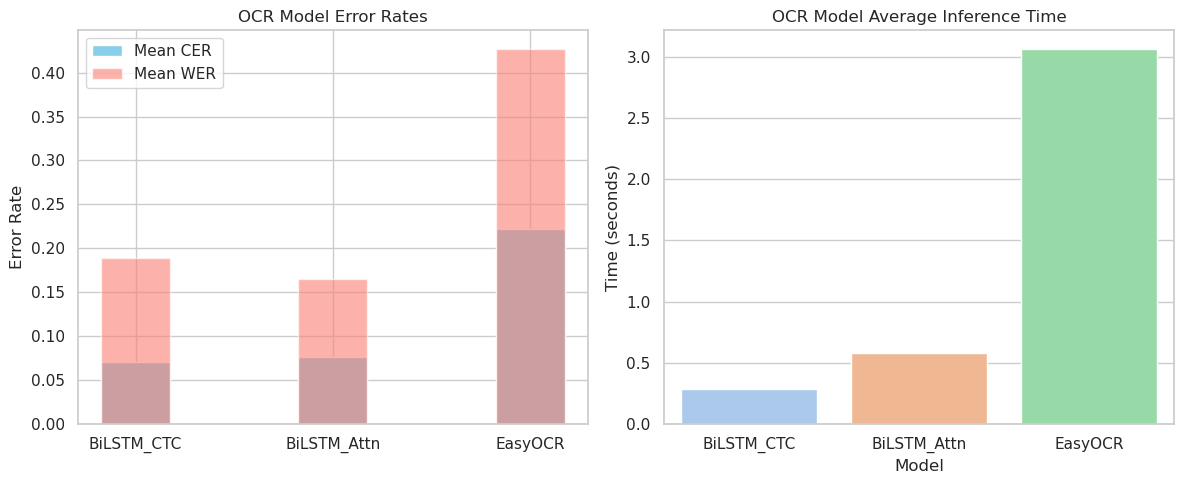

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load the summary if needed
summary = pd.read_csv("inference_accuracy_summary.csv")

sns.set(style="whitegrid")
plt.figure(figsize=(12, 5))

# --------- Plot Mean CER and WER ---------
plt.subplot(1, 2, 1)
bar_width = 0.35
x = summary["Model"]

# CER
plt.bar(x, summary["Mean CER"], width=bar_width, label="Mean CER", color="skyblue")
# WER (shift bars to the right)
plt.bar([i for i in range(len(x))], summary["Mean WER"], width=bar_width, alpha=0.6, label="Mean WER", color="salmon")

plt.title("OCR Model Error Rates")
plt.ylabel("Error Rate")
plt.xticks(range(len(x)), x)
plt.legend()

# --------- Plot Avg Inference Time ---------
plt.subplot(1, 2, 2)
sns.barplot(x="Model", y="Avg Inference Time (s)", data=summary, palette="pastel")
plt.title("OCR Model Average Inference Time")
plt.ylabel("Time (seconds)")

plt.tight_layout()
plt.show()


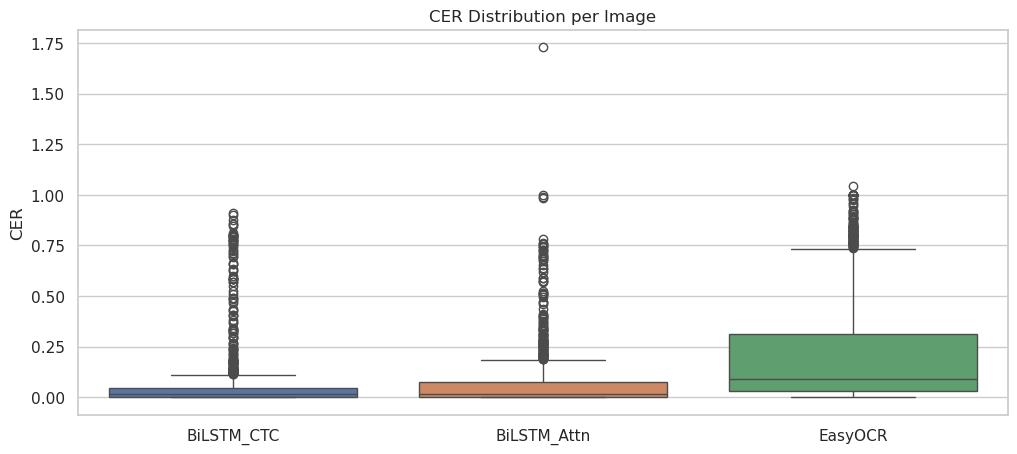

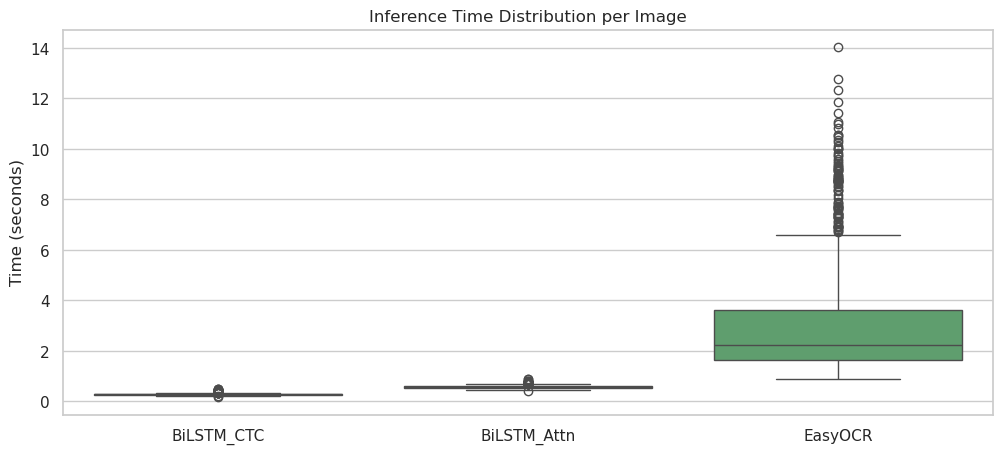

In [9]:
# Load detailed results
results_df = pd.read_csv("inference_accuracy_detailed_results.csv")

plt.figure(figsize=(12,5))
sns.boxplot(data=results_df[["ctc_cer","attn_cer","easy_cer"]])
plt.xticks([0,1,2], ["BiLSTM_CTC", "BiLSTM_Attn","EasyOCR"])
plt.title("CER Distribution per Image")
plt.ylabel("CER")
plt.show()

plt.figure(figsize=(12,5))
sns.boxplot(data=results_df[["ctc_time","attn_time","easy_time"]])
plt.xticks([0,1,2], ["BiLSTM_CTC", "BiLSTM_Attn","EasyOCR"])
plt.title("Inference Time Distribution per Image")
plt.ylabel("Time (seconds)")
plt.show()
